**Contact:** Corentin Ravoux (CPPM) : corentin.ravoux.research@gmail.com

--------

# Mount Drive and Collect data

--------


**Before starting, click on [this folder](https://drive.google.com/drive/folders/1FRNzxto4hvF91aa5wnyRccZ7HgXAoBNZ?usp=sharing) and create a shortcut to your google drive by following these steps:**

*   In the top, click on the arrow next to the name of the folder "Lyman alpha MACSS 2023"
*   Click Create Shortcut in Drive
*   Choose My Drive (in "All" tab)

**In the folder "Lyman-alpha tomography/tutorial", right click on the notebook (.ipynb) you are working on and create a copy in your drive (not a shortcut)**

**Alternative:** This notebook can be downloaded along with the associated data to work on your laptop. Change the path_to_data accordingly.

In [1]:
# Define the path where the data are stored
from google.colab import drive
drive.mount('/content/drive')
path_to_data="/content/drive/My Drive/Lyman alpha MACSS 2023/Lyman-alpha tomography/tutorial/data/"

Mounted at /content/drive


In [2]:
# Install the packages we need
%%capture
!pip install fitsio
!pip install git+https://github.com/corentinravoux/lelantos

In [3]:
# Import the packages we need

import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(os.path.join(path_to_data,"style.mplstyle"))
import fitsio
from scipy.ndimage.filters import gaussian_filter
from lelantos import utils
import ipywidgets as widgets

<ipython-input-3-8ee5ead378b9>:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [4]:
# Some usefull function given to you, totally free.

def read_delta_file(name_file):
  delta_file = fitsio.FITS(os.path.join(path_to_data, name_file))
  ra,dec, delta, sigma, wavelength, continuum = [], [], [], [], [], []
  for i in range(1,len(delta_file)):
    wave = delta_file[i]["LAMBDA"].read()
    wavelength.append(wave)
    header = delta_file[i].read_header()
    ra.append(np.array([np.degrees(header["RA"]) for i in range(len(wave))]))
    dec.append(np.array([np.degrees(header["DEC"]) for i in range(len(wave))]))
    delta.append(delta_file[i]["DELTA_BLIND"].read())
    continuum.append(delta_file[i]["CONT"].read())
    ivar = delta_file[i]["IVAR"].read()
    sigma.append(1/np.sqrt(ivar))
  delta_file.close()
  return(np.concatenate(ra,axis=0),
         np.concatenate(dec,axis=0),
         np.concatenate(wavelength,axis=0),
         np.concatenate(continuum,axis=0),
         np.concatenate(delta,axis=0),
         np.concatenate(sigma,axis=0))




def read_galaxies(name_file):
  f = fitsio.FITS(name_file)[1]
  X_gal = f["X"].read()
  Y_gal = f["Y"].read()
  Z_gal = f["Z"].read()
  return(X_gal,Y_gal,Z_gal)


--------

# Lyman-α tomography in DESI (Dark Energy Spectroscopic Instrument):

--------


###**In this tutorial, we will try to understand the Lyman-alpha forest coming from DESI, and try to reproduce a 3D map of Lyman-alpha absorption with those data.**
###**For more detail, check https://arxiv.org/abs/2004.01448.**


### **The parts of this tutorial are independent. You can move on if you are stuck**



## 1. What is a Lyman-alpha forest (5 min):

DESI is a multi-object spectrograph conducting a five-year survey that measures the spectra of galaxies and quasars. 

Here, we are interested in observing quasars (supermassive black hole + accretion disk) which are among the brightest known objects of our Universe (100 times the Milky Way). As they are very bright, they can be seen very far, and consequently very early in the past (up to 12 billion years ago).

We will use the spectra of quasars with a redshift higher than 2.0, for which we can observe from the ground the Lyman-alpha emission line (121.567 nm). The quasar is so far that the light it emits in the UV is optic for us.

Near the Lyman-alpha emission line, a series of Lyman-alpha absorption features, called **Lyman-alpha forest**, corresponds to absorption by the matter between the quasar and us. In https://www.pontzen.co.uk/media/dla_credited.mov, you can see an example of the formation of a forest.


## 2. Understanding the data (15 min):

The pre-processing of the Lyman-alpha forest was done previously. You have a set of forests at your disposition that originates from the quasars observed by DESI.


The following reads the data for you:


In [5]:
name_delta_file = "delta-94.fits.gz"
(ra,dec,wavelength,continuum,delta,sigma) = read_delta_file(name_delta_file)


The data you have contains the coordinates on the sky where the quasars are located:
- **ra**: right-ascension
- **dec**: declination 
For more info, see https://en.wikipedia.org/wiki/Equatorial_coordinate_system

It contains the Lyman-alpha observed on each quasar:
- **wavelength**: wavelenght for which the forest is observed (redshift compared to the quasar rest-frame)
- **continuum**: The unabsorbed flux of the quasar.
- **delta**: Lyman-alpha forest variation (the quantity that interests us)

      delta = (flux/continuum) - 1

- **sigma**: Noise (Error) associated to the forest

You can play a little with the data to understand them. All data are stored in numpy arrays, and all have the same size:

In [6]:
print(ra.shape,dec.shape,wavelength.shape,continuum.shape,delta.shape,sigma.shape)

(385378,) (385378,) (385378,) (385378,) (385378,) (385378,)


---
**Your turn**

---

To check how your data are located in the sky, plot dec as a function of ra.

What you will see is an observation of DESI, which can measure the spectra of several objects at once

Text(0, 0.5, 'DEC [degree]')

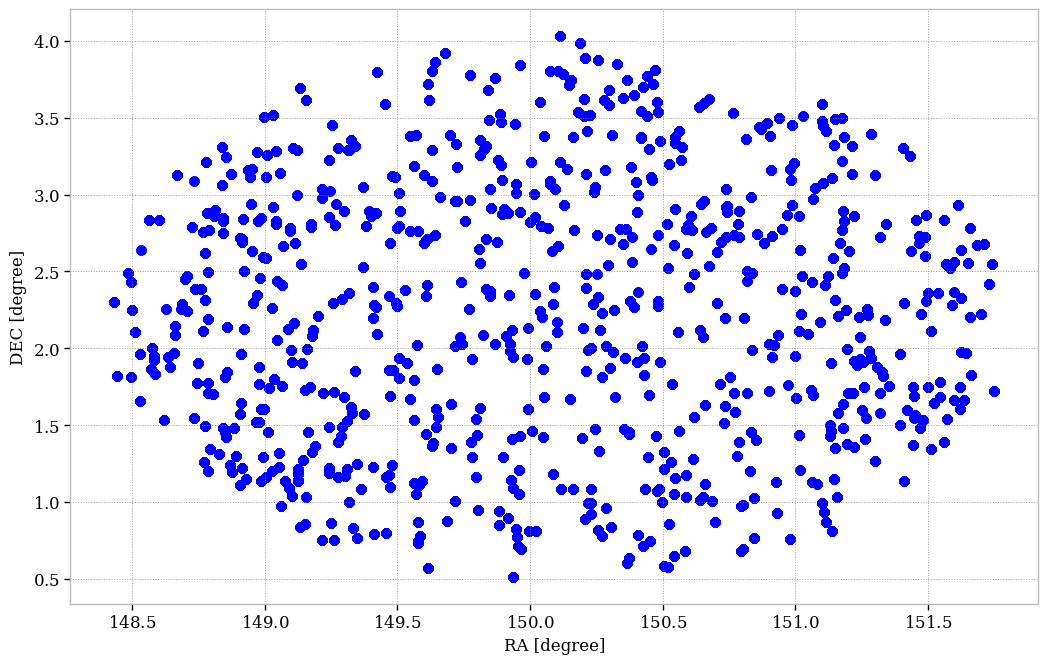

In [7]:
# Plotting of a RA, DEC diagram
plt.scatter(ra,dec)
plt.xlabel('RA [degree]')
plt.ylabel('DEC [degree]')


So, now we see where our quasars are located in the sky. 

Are we able to see the Lyman-alpha forest of one of them?
I selected for you here the pixels for which you can see a nice forest:

In [8]:
delta_nice_forest = delta[15017:15680]
continuum_nice_forest = continuum[15017:15680]
wavelength_nice_forest = wavelength[15017:15680]

---
**Your turn**

---

Now, try to plot the flux we observed for this forest and the estimated quasar continuum. 

The continuum is already given to you, and the formula to compute flux is given previously.


Additionally, before plotting, you can smooth the flux of your spectra with this function:

      flux_nice_forest = gaussian_filter(flux_nice_forest, sigma_smooth)

Try to vary sigma_smooth (from 1 to 5)

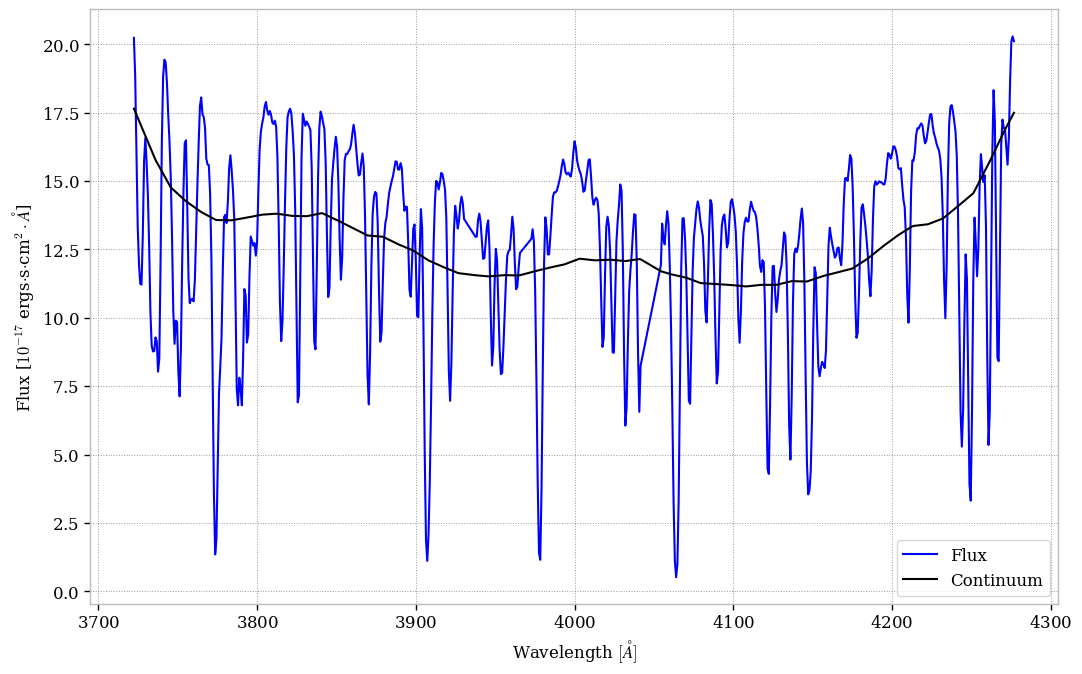

In [9]:
# compute flux of the forest, and smooth it if you want
flux_nice_forest = (delta_nice_forest+1)*continuum_nice_forest
flux_nice_forest = gaussian_filter(flux_nice_forest, 1)

# plot the flux and continuum
plt.plot(wavelength_nice_forest,flux_nice_forest)
plt.plot(wavelength_nice_forest,continuum_nice_forest,"k")
plt.xlabel(r"Wavelength $[\AA]$")
plt.ylabel('Flux [$10^{-17}$ ergs$\cdot$s$\cdot$cm$^2 \cdot \AA$]')
plt.legend(["Flux","Continuum"])

The flux, and renormalized the delta, give you the intergalactic medium's absorption along the line-of-sight, between the quasar and us (humans on our little rock).

The absorption is directly related to the quantity of matter (neutral hydrogen, more precisely) between the quasar and us. So what you have here is the **profile of matter in a region of the Universe located at more than 12 billion light-years**! Nice, right? And this by using the light of one of the brightest and furthest objects possibly observable.


## 3. Creating the input of the Lyman-alpha tomographic map (30 min):

We want to create the input that will be used to create the 3D map of Lyman-alpha forest. 
Let's start again with clean data, run the following cell:

In [10]:
name_delta_file = "delta-94.fits.gz"
(ra,dec,wavelength,continuum,delta,sigma) = read_delta_file(name_delta_file)

---
**Your turn**

---

Ok, now let's compute the redshift of the absorbers in the intergalactic medium that create these forest. 

Easy, the relation is:

        1 + redshift = (wavelength/wavelength_lya_rest_frame)

In the rest-frame, this absorption is the Lyman-alpha emission line. I will give it to you here.

In [11]:
wavelength_lya = 1215.673123130217 


# compute redshift
redshift = (wavelength/ wavelength_lya) - 1
print(redshift.shape)

(385378,)


Now, we want to create a 3D map of absorption.

First, we only have the coordinates in angle and redshift. We want to compute the distance between all of these absorbers.

First, let me cut only the Lyman-alpha forest pixel we need. Just execute the following:

In [12]:
zmin, zmax = 2.1, 3.5
ramin, ramax = 148.100, 152.100
decmin, decmax = 0.182, 4.182
mask = (ra > ramin) & (ra < ramax) & (dec > decmin) & (dec < decmax) & (redshift > zmin) & (redshift < zmax)
ra, dec, redshift, delta, sigma = ra[mask], dec[mask], redshift[mask], delta[mask], sigma[mask]
print(ra.shape,dec.shape,redshift.shape,delta.shape,sigma.shape)

(283118,) (283118,) (283118,) (283118,) (283118,)


Hereafter, we will work with the cleaned data.
As I mentioned, we need to compute the distance between absorbers. We are in cosmology, and the Universe is expanding, so computing the distances between two points in a curved Universe depends on the object's redshift. Thankfully, we have the general relativity and the Friedmann-Lemaitre-Robertson-Walker metric.

We need:
- The comoving distance (Dc) will show how distant from us an object is.
- The transverse comoving distance (Dm) gives you the distance between two objects separated by an angle.

I give you this function **rcomov** (Dc) and **distang** (Dm). But if you want to compute them, go on; that is fun. Here is a link that will help you: https://arxiv.org/abs/astro-ph/9905116.

The definition of this distance depends on cosmological parameters, particularly on Omega_m, the energetic density of matter (classical matter + dark matter).

In [13]:
%%capture
Omega_m = 0.3147
(rcomov,distang,inv_rcomov,inv_distang) = utils.get_cosmo_function(Omega_m)

We choose to create the 3D map in a box with parallel lines-of-sight. The transformation from sky coordinates to cartesian for this is:


      X = Dm(<z>)*RA
      Y = Dm(<z>)*DEC
      Z = Dc(z)

where $\langle z \rangle$ is the average between the maximal and minimal redshift of the data.



---
**Your turn**

---

Compute the X, Y, and Z arrays.

In [14]:
# First compute <z> and then X, Y, Z
mean_redshift = (np.min(redshift) + np.max(redshift))/2
X = distang(mean_redshift)*np.radians(ra)
Y = distang(mean_redshift)*np.radians(dec)
Z = rcomov(redshift)

---
**Your turn**

---

We want to normalize all the coordinates to have the lower corner of the 3D box with coordinates (0,0,0)

subtract X, Y, and Z by their minimal value:

In [15]:
# Subtraction of the minimal coordinates
X = X - np.min(np.asarray(X))
Y = Y - np.min(np.asarray(Y))
Z = Z - np.min(np.asarray(Z))

Let's see if you have the correct data. Just execute this:

In [16]:
try:
  my_pixel = np.transpose(np.stack([X,Y,Z,sigma,delta]))
  the_pixel = np.fromfile(os.path.join(path_to_data,"pixel_desi_cosmos.bin"),dtype=np.float64)
  the_pixel = the_pixel.reshape((len(the_pixel)//5,5))
  it_is_ok = np.allclose(my_pixel, the_pixel, rtol=1e-05)
except:
  it_is_ok = False
print("The results of the comparison is:")
if(it_is_ok):
  display(widgets.HTML(f'<img src="https://c.tenor.com/H6sjheSkU1wAAAAC/noice-nice.gif" width="300" align="center">'))
else:
  display(widgets.HTML(f'<img src="https://c.tenor.com/ADQ0ittXUJEAAAAd/rick-and-mortey-disqualified.gif" width="400" align="center">'))
# Memes with jupyter notebook, noice

The results of the comparison is:


HTML(value='<img src="https://c.tenor.com/H6sjheSkU1wAAAAC/noice-nice.gif" width="300" align="center">')

If you failed previously, that is ok, do not stay stuck here. I will give you the data anyway.

## 4. Plotting the tomographic map (30 min):


We want to create a 3D map of Lyman-alpha absorption from the data you proceeded previously. To create this map, I used a Wiener filter, an interpolator based on a Gaussian kernel that considers the noise associated with the Lyman-alpha forest.

We could have run this algorithm inside the notebook, but it would take some time. Let's just say we did it. The map we obtained is loaded here:


In [17]:
the_pixel = np.fromfile(os.path.join(path_to_data,"pixel_desi_cosmos.bin"),dtype=np.float64)
the_pixel = the_pixel.reshape((len(the_pixel)//5,5))
X,Y,Z,sigma,delta = the_pixel[:,0],the_pixel[:,1],the_pixel[:,2],the_pixel[:,3],the_pixel[:,4]
name_map = os.path.join(path_to_data,"map_reconstructed.bin")


shape = (232, 232, 1000)
size = (246.04243972050972, 261.06212780808994, 1009.5157627177641)
map = np.fromfile(name_map,dtype=np.float64).reshape(shape)

This map has an associated size in Mpc, and a shape (the number of pixels of the map). What you have is a three-dimensional numpy array.

In [18]:
print(map.shape)

(232, 232, 1000)


We want to plot a 2D slice of this map. For this, we will use the matplotlib function:

        plt.imshow()

If you do not know how it works, Google is here.

I give you:
- **X_plot**: the distance at which we want to plot the map in the X direction
- **dX_plot**: we want to add to the plot the Lyman-alpha forest located at plus or minus dX_plot
- **extent**: A little help for you, in the imshow function, add extent = extent to have the correct coordinates in the plot.
- **mpc_per_pixel**: Another help (I'm so generous): how we convert the distance to coordinate in the map along the X-direction.

In [19]:
X_plot = 165 # Mpc
dX_plot = 5 # Mpc
extent = [0,size[2],size[1],0]
mpc_per_pixel = (np.array(size)/(np.array(shape)-1))[0]

---
**Your turn**

---

Try to plot a slice of the map at the distance X_plot as well as all the Lyman-alpha forests located between 

        X_plot - dX_plot and X_plot + dX_plot

Bonus: plot the quasar associated with each Lyman-alpha forest by considering they are located at 50 Mpc of the Lyman-alpha forest.

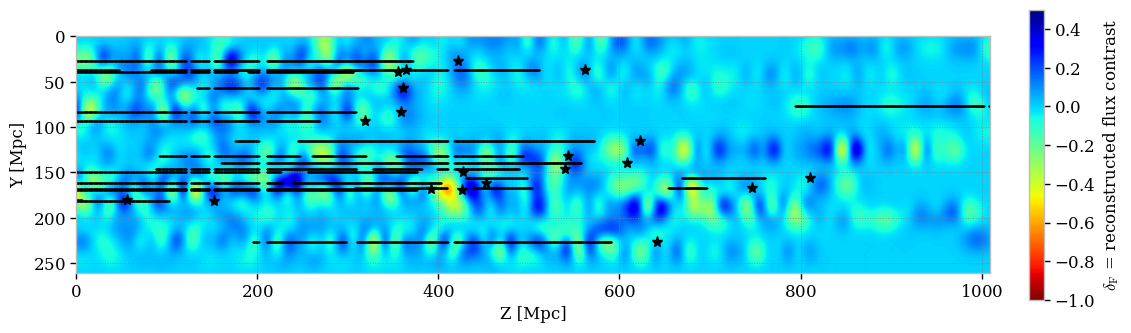

In [20]:
# Plot the map slice
coord_map = int(np.around(X_plot / mpc_per_pixel,0))
plt.imshow(map[coord_map,:,:],vmin=-1.0,vmax=0.5,cmap = "jet_r",extent = extent)


# Plot the Lyman-alpha forests
mask = (X < X_plot + dX_plot)&(X > X_plot - dX_plot)
plt.plot(Z[mask],Y[mask],marker=".",linestyle='None',color="k",markersize=1)
plt.xlabel("Z [Mpc]")
plt.ylabel("Y [Mpc]")
c = plt.colorbar(fraction=0.015, pad=0.04)
c.set_label(r"$\delta_{\mathrm{F}}$ = reconstructed flux contrast")

# Bonus
Y_unique = np.unique(Y[mask])
Z_QSO, Y_QSO = [], []
for i in range(len(Y_unique)):
  mask_Y = Y == Y_unique[i]
  if(np.max(Z[mask_Y]) + 50 < size[2]):
    Z_QSO.append(np.max(Z[mask_Y]) + 50)
    Y_QSO.append(Y_unique[i])
plt.plot(Z_QSO,Y_QSO,marker="*",linestyle='None',color="k",markersize=8)


## 5. Some applications:


I give you here a catalog of high-redshift galaxies observed on the same footprint. 

In [21]:
galaxy_file = os.path.join(path_to_data,"LBG_catalog.fits")
(X_gal,Y_gal,Z_gal) = read_galaxies(galaxy_file)

---
**Your turn**

---

Plot the same slice but with Lyman-forest, and with the position of these new galaxies

Text(0, 0.5, 'Y [Mpc]')

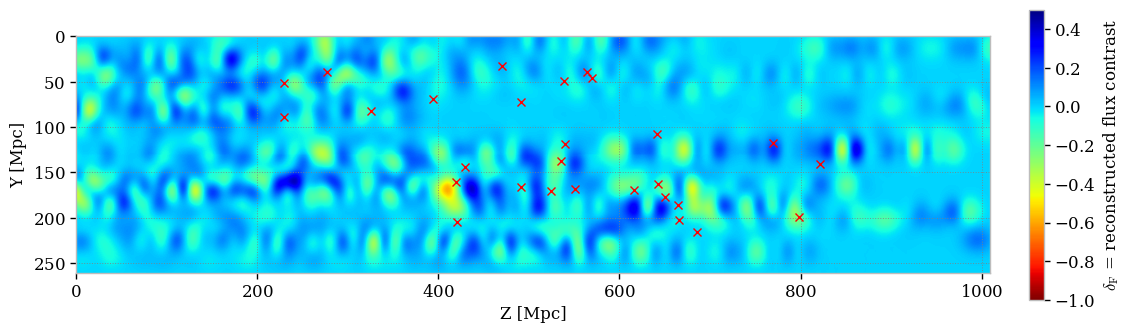

In [22]:
# Plot the map slice
coord_map = int(np.around(X_plot / mpc_per_pixel,0))
plt.imshow(map[coord_map,:,:],vmin=-1.0,vmax=0.5,cmap = "jet_r",extent = extent)
c = plt.colorbar(fraction=0.015, pad=0.04)
c.set_label(r"$\delta_{\mathrm{F}}$ = reconstructed flux contrast")

# Plot the galaxies
mask_gal = (X_gal < X_plot + dX_plot)&(X_gal > X_plot - dX_plot)
plt.plot(Z_gal[mask_gal],Y_gal[mask_gal],marker="x",linestyle='None',color="r")
plt.xlabel("Z [Mpc]")
plt.ylabel("Y [Mpc]")

Now, you can try to compute the average absorption around these galaxies. For that, you need to extract a submap with:

- with a size between **-size_stack** and **+size_stack** along each direction, 
- and a shape **shape_stack**,

around each galaxy. Once you have all the sub-maps, compute the average submap. 

Be careful to have all the submap with the same shape (remove the one at the border).

In [23]:
size_stack = 30
shape_stack = (20,20,20)
x_array = np.linspace(-size_stack,size_stack,2*shape_stack[0]+1)
y_array = np.linspace(-size_stack,size_stack,2*shape_stack[1]+1)
z_array = np.linspace(-size_stack,size_stack,2*shape_stack[2]+1)
coord_stack = np.moveaxis(np.array(np.meshgrid(x_array,y_array,z_array,indexing='ij')),0,-1)
coord_gal = np.transpose(np.stack([X_gal,Y_gal,Z_gal]))

---
**Your turn**

---

I gave you the first step, go on then:

In [24]:
# Fill the local_maps array with submaps
local_maps = []
for i in range(len(coord_gal)):
  coord_stack_local = coord_stack + coord_gal[i]
  index_stack_local = coord_stack_local/(np.array(size)/(np.array(shape)-1))
  boolean = (np.max(index_stack_local[:,:,:,0])>=shape[0])
  boolean |=(np.min(index_stack_local[:,:,:,0])<0)
  boolean |=(np.max(index_stack_local[:,:,:,1])>=shape[1])
  boolean |=(np.min(index_stack_local[:,:,:,1])<0)
  boolean |=(np.max(index_stack_local[:,:,:,2])>=shape[2])
  boolean |=(np.min(index_stack_local[:,:,:,2])<0)
  if(not(boolean)):
    index_stack_local = np.around(index_stack_local,decimals=0).astype(int)
    local_maps.append(map[index_stack_local[:,:,:,0],index_stack_local[:,:,:,1],index_stack_local[:,:,:,2]])


# Average of the submaps
local_maps = np.array(local_maps)
stack = np.mean(local_maps,axis=0)


---
**Your turn**

---

You can plot the submap and obtain the mean profile around galaxies. It should be negative.

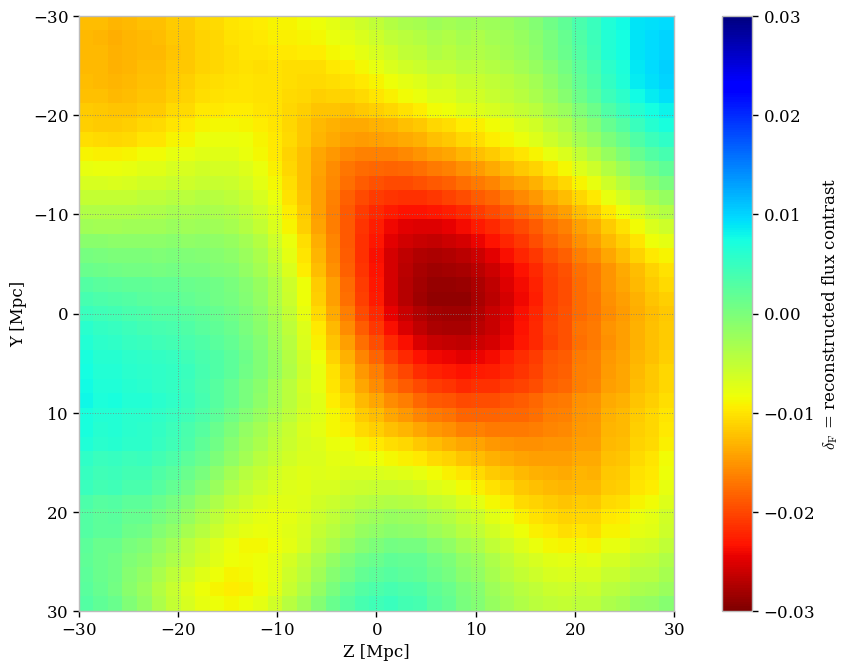

In [25]:
# Plot the stack
extent_stack = [-size_stack,size_stack,size_stack,-size_stack]
plt.imshow(stack[20,:,:],vmin=-0.03,vmax=0.03,cmap = "jet_r",extent = extent_stack)
plt.xlabel("Z [Mpc]")
plt.ylabel("Y [Mpc]")
c = plt.colorbar()
c.set_label(r"$\delta_{\mathrm{F}}$ = reconstructed flux contrast")

Another important application will be detailed in the project associated with this tutorial. This project aims to create an algorithm that can detect the underdense regions in a tomographic map called cosmic voids.

By correlating the void positions with the Lyman-alpha forests used to create the map, we can measure the Lyman-alpha/Void cross-correlation as in https://arxiv.org/abs/2203.11045.

This finder can also be used to detect overdense regions on the map, which are called proto-clusters.